In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import sys
sys.path.append('../')

from intersections_and_roads import *
from shapely.geometry import *
import ast

In [2]:
intersections_points = gpd.read_file('../sf_data/street_intersections.geojson')
street_centerlines = gpd.read_file('../sf_data/San_Francisco_Basemap_Street_Centerlines.geojson')
street_centerlines_2 = gpd.read_file('../sf_data/street_intersections.geojson')

In [3]:
street_centerlines_2.columns


Index([u'cnn', u'cnntext', u'geometry', u'st_name', u'st_type'], dtype='object')

In [40]:
# bike_accidents = pd.read_json('../sf_data/sanfrancisco_crashes.json')
import json
with open('../sf_data/sanfrancisco_crashes.json') as sf_data:    
    bike_accidents = json.load(sf_data)

# # bike_accidents = json.loads('../sf_data/sanfrancisco_crashes.json')

In [41]:
from pandas.io.json import json_normalize
bike_accidents_df = json_normalize(bike_accidents['accidents'])
bike_accidents_df.head(5)
# type(json_normalize(bike_accidents['accidents']))

date  image_id        lat         lng  severity  street1  \
0  u'20120409         0  37.772648 -122.415014  u'INJURY  11th St   
1  u'20120419         1  37.772413 -122.414716  u'INJURY  11th St   
2  u'20120313         2  37.773208 -122.470169  u'INJURY  12th Av   
3  u'20120306         3  37.770929 -122.415047  u'INJURY  12th St   
4  u'20120118         4  37.769632 -122.413332  u'INJURY  13th St   

       street2  year  
0  Kissling St  2012  
1       Market  2012  
2    Fulton St  2012  
3    Folsom St  2012  
4  Harrison St  2012

In [16]:
bike_accidents_df['Street_ID'] = 0
street_centerlines.columns

Index([  u'accepted',  u'classcode',        u'cnn',    u'cnntext',
         u'district', u'f_node_cnn',   u'geometry', u'jurisdicti',
            u'layer',    u'lf_fadd',   u'lf_toadd',  u'multigeom',
            u'nhood',     u'oneway',    u'rt_fadd',   u'rt_toadd',
          u'st_type',     u'street',  u'street_gc', u'streetname',
       u't_node_cnn',   u'zip_code'],
      dtype='object')

In [14]:
for i in range(len(bike_accidents_df)):
    new_point = Point(bike_accidents_df['lng'][i], bike_accidents_df['lat'][i])
    test_distances = [new_point.distance(x) for x in street_centerlines['geometry']]
    index = np.argmin(test_distances)
    bike_accidents_df.iloc[i]['Street_ID'] = street_centerlines.iloc[index]['id']
    

KeyError: 'id'

In [7]:
bike_crashes_per_street = bike_accidents_df.groupby(['Street_ID'], as_index=False).size().reset_index()

In [8]:
bike_crashes_per_street.rename(index=str, inplace=True, columns={0: 'num_accidents'})

In [9]:
bike_crashes_per_street.head()

Street_ID  num_accidents
0          0            307

In [68]:
bike_crashes_per_street.to_pickle("sf_bike_crashes.pkl")

In [4]:
bike_crashes_per_street = pd.read_pickle("../sf_data/sf_bike_crashes.pkl")

In [5]:
bike_crashes_per_street.head(5)

Street_ID  num_accidents
0     512000              1
1     513000              1
2     544000              1
3     590000              1
4     595000              1

In [21]:
street_centerlines[street_centerlines['id']==512000]

KeyError: 'id'

In [145]:
sf_elevation = pd.read_csv('../sf_data/node_elevation_2.csv', delimiter=' ', header=None, names=['id', 'elevation'])

In [146]:
sf_elevation['id'] = sf_elevation['id'].astype(int)
sf_elevation.head(5)

id   elevation
0  27380000  116.943794
1  22138000   59.435978
2  20758000    5.100687
3  27459000   61.947712
4  51958000    3.171112

In [24]:
def f(x):    
    return Point(x['lon'],x['lat']) 
sf_elevation['point']=sf_elevation[['lon', 'lat']].apply(f, axis=1)
# print sf_elevation[['lon','lat']]['lon']
# for i in range(len(sf_elevation)):
#     sf_elevation.iloc[i]['point'] = Point(sf_elevation.iloc[i]['lon'],sf_elevation.iloc[i]['lat'])

KeyError: "['lon' 'lat'] not in index"

In [6]:
sf_elevation.head(5)

id   elevation
0  27380000  116.943794
1  22138000   59.435978
2  20758000    5.100687
3  27459000   61.947712
4  51958000    3.171112

In [15]:
# def elev(node):
# #     print node
#     point = Point(node.get_x_y()[0], node.get_x_y()[1])
#     dist = [point.distance(elev_point) for elev_point in sf_elevation['point']]
#     closest = np.argmin(dist)
#     return sf_elevation.iloc[closest]['alt']

In [43]:
def elev(node):
#     print node
#     point = Point(node.get_x_y()[0], node.get_x_y()[1])
#     dist = [point.distance(elev_point) for elev_point in sf_elevation['point']]
#     closest = np.argmin(dist)
#     print int(node.id)
    return sf_elevation[sf_elevation['id']==int(node.id)]['elevation']

In [8]:
street_centerlines['ToNode'] = street_centerlines['t_node_cnn'].astype(np.int32)
street_centerlines['FromNode'] = street_centerlines['f_node_cnn'].astype(np.int32)
street_centerlines['id'] =  street_centerlines['cnn'].apply(lambda x: int(float(x)))
# Get the direction
street_centerlines['Direction'] = street_centerlines['oneway'].apply(lambda x: 0 if x == 'B' else 1 if x == 'F' else -1)
street_centerlines.head(2)

accepted classcode         cnn   cnntext district f_node_cnn  \
0        N         0  15145000.0  15145000     None   26132000   
1        Y         0  11305001.0  11305001     None   26255000   

                                            geometry jurisdicti    layer  \
0  LINESTRING (-122.4469424451799 37.757228921523...       None  PRIVATE   
1  LINESTRING (-122.4479152656158 37.757589498018...        DPW    UPROW   

  lf_fadd    ...    st_type         street      street_gc         streetname  \
0     0.0    ...         CT          CROWN          CROWN           CROWN CT   
1     1.0    ...        AVE  SAINT GERMAIN  SAINT GERMAIN  SAINT GERMAIN AVE   

  t_node_cnn zip_code    ToNode  FromNode        id Direction  
0   54223000    94114  54223000  26132000  15145000         0  
1   54224000    94114  54224000  26255000  11305001         0  

[2 rows x 26 columns]

In [9]:
intersections_points['NodeNumber'] = intersections_points['cnntext'].apply(lambda x: int(float(x)))
intersections_points['id'] = intersections_points['cnntext']
intersections_points.head(2)

cnn   cnntext                                      geometry st_name  \
0  23730000  23730000  POINT (-122.4054541718919 37.75433723137436)    UTAH   
1  22141000  22141000  POINT (-122.4397477601416 37.73236806396732)   JOOST   

  st_type  NodeNumber        id  
0      ST    23730000  23730000  
1     AVE    22141000  22141000

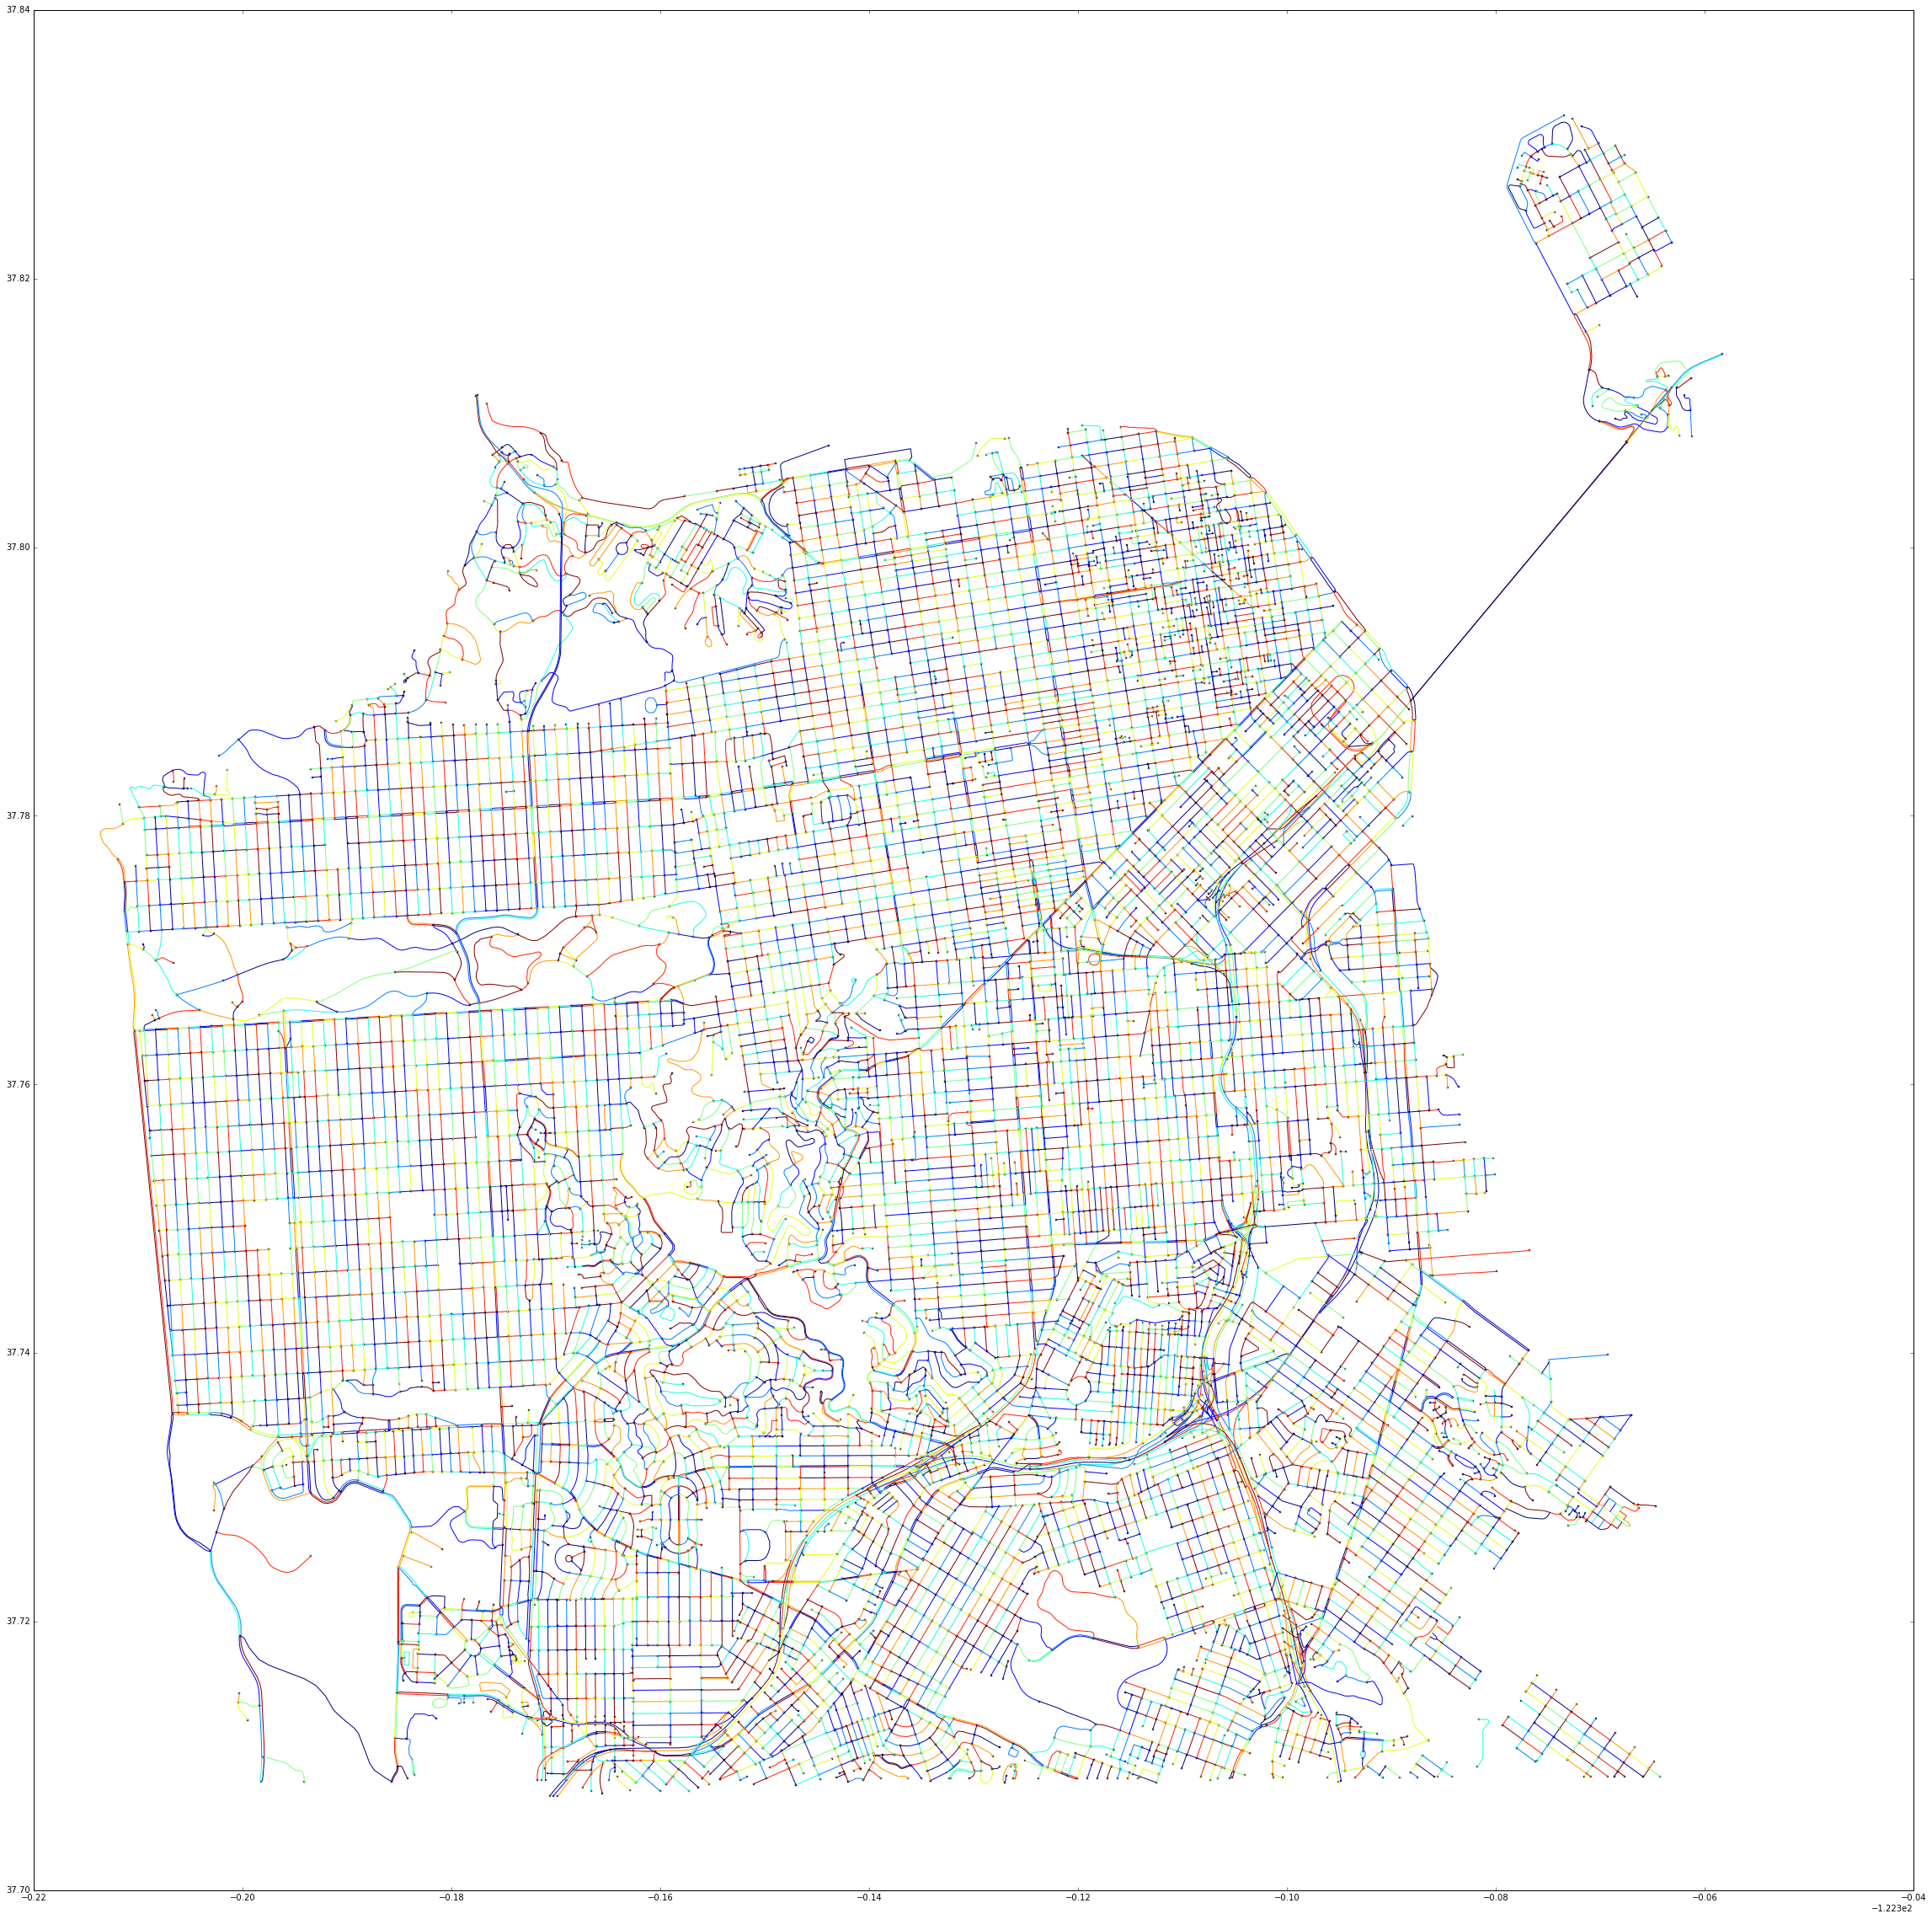

In [5]:
fig, ax = plt.subplots(1,1, figsize=(40,40))
intersections_points.plot(ax=ax)
street_centerlines.plot(ax=ax)

In [10]:
intersection_graph, connection_dict = build_intersection_graph(intersections_points, street_centerlines, sf_elevation, bike_crashes_per_street)

In [11]:
intersections_points.head()

cnn   cnntext                                      geometry  \
0  23730000  23730000  POINT (-122.4054541718919 37.75433723137436)   
1  22141000  22141000  POINT (-122.4397477601416 37.73236806396732)   
2  27966000  27966000  POINT (-122.5109259470119 37.77043567583329)   
3  21349000  21349000  POINT (-122.4226694452744 37.74394224109009)   
4  24388000  24388000  POINT (-122.4186182163472 37.77305345411757)   

          st_name st_type  NodeNumber        id  
0            UTAH      ST    23730000  23730000  
1           JOOST     AVE    22141000  22141000  
2  JOHN F KENNEDY      DR    27966000  27966000  
3        SAN JOSE     AVE    21349000  21349000  
4         MISSION      ST    24388000  24388000

In [ ]:
bike_crashes_per_street = pd.read_pickle("../sf_data/sf_bike_crashes.pkl")
for street in bike_crashes_per_street.itertuples():
    if connection_dict.get(street[1], None):
        connection_dict[street[1]].add_accidents(street[2])

In [30]:
# node_elevation = []
for node in intersection_graph.values():
    node.set_elevation(elev(node))
#     node_elevation.append([node.id, node.elevation])
#     if len(node_elevation)%1000==0:
#         print len(node_elevation)

In [36]:
print len(node_elevation)
np_elevation = np.array(node_elevation)
np_elevation_float = np_elevation.astype('float64')

print np_elevation_float.dtype

np.savetxt("node_elevation_2.csv", np_elevation_float)

9645
float64


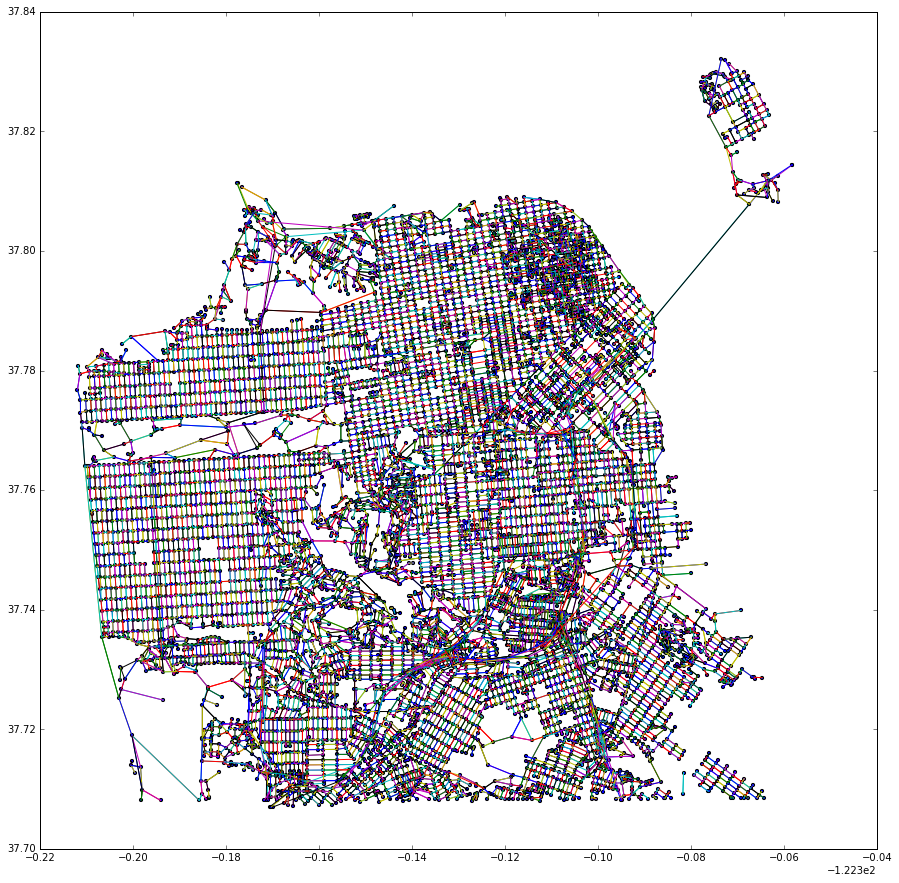

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))

xs = [intersection_graph[key].get_x_y()[0] for key in intersection_graph]
ys = [intersection_graph[key].get_x_y()[1] for key in intersection_graph]

for key in intersection_graph:
    node = intersection_graph[key]
    for connection in node.get_connections():
        child = connection_dict[connection]
        line_x = [child.get_source(intersection_graph).get_x_y()[0], child.get_target(intersection_graph).get_x_y()[0]]
        line_y = [child.get_source(intersection_graph).get_x_y()[1], child.get_target(intersection_graph).get_x_y()[1]]
        ax.plot(line_x, line_y)

ax.scatter(xs, ys, s=10)
plt.show()

In [136]:
# lat = np.apply_along_axis(lambda p: p.x, 1, bike_accident_locations[['geometry']].values,)
accident_lat = bike_accidents_df['lat']
accident_lng = bike_accidents_df['lng']

In [147]:
sf_elevation.head()

id   elevation
0  27380000  116.943794
1  22138000   59.435978
2  20758000    5.100687
3  27459000   61.947712
4  51958000    3.171112

In [50]:
intersections_points.head()

cnn   cnntext                                      geometry  \
0  23730000  23730000  POINT (-122.4054541718919 37.75433723137436)   
1  22141000  22141000  POINT (-122.4397477601416 37.73236806396732)   
2  27966000  27966000  POINT (-122.5109259470119 37.77043567583329)   
3  21349000  21349000  POINT (-122.4226694452744 37.74394224109009)   
4  24388000  24388000  POINT (-122.4186182163472 37.77305345411757)   

          st_name st_type  NodeNumber        id  
0            UTAH      ST    23730000  23730000  
1           JOOST     AVE    22141000  22141000  
2  JOHN F KENNEDY      DR    27966000  27966000  
3        SAN JOSE     AVE    21349000  21349000  
4         MISSION      ST    24388000  24388000

In [53]:
intersections_points[intersections_points['id'] == '27380000']

cnn   cnntext                                     geometry  \
2992   27380000  27380000  POINT (-122.4817021076013 37.7521400039038)   
15549  27380000  27380000  POINT (-122.4817021076013 37.7521400039038)   

      st_name st_type  NodeNumber        id  
2992     24TH     AVE    27380000  27380000  
15549  ORTEGA      ST    27380000  27380000

In [162]:
intersections_points['id'] = intersections_points['id'].astype(int)

In [163]:
node_elev_locations = sf_elevation.merge(intersections_points, on='id', how='right')

In [164]:
node_elev_locations.head()

id   elevation       cnn   cnntext  \
0  27380000  116.943794  27380000  27380000   
1  27380000  116.943794  27380000  27380000   
2  22138000   59.435978  22138000  22138000   
3  22138000   59.435978  22138000  22138000   
4  20758000    5.100687  20758000  20758000   

                                       geometry st_name st_type  NodeNumber  
0   POINT (-122.4817021076013 37.7521400039038)    24TH     AVE    27380000  
1   POINT (-122.4817021076013 37.7521400039038)  ORTEGA      ST    27380000  
2   POINT (-122.4420102145921 37.7299109493234)   CONGO      ST    22138000  
3   POINT (-122.4420102145921 37.7299109493234)   FLOOD     AVE    22138000  
4  POINT (-122.3996854877209 37.73990197393803)   SELBY      ST    20758000

In [203]:
elev_lat = node_elev_locations['geometry'].apply(lambda p: p.y)
elev_lng = node_elev_locations['geometry'].apply(lambda p: p.x)
elev_vals = node_elev_locations['elevation'].values

In [194]:
elev_vals

array([ 116.9437943 ,  116.9437943 ,   59.43597794, ...,   89.27294922,
         89.27294922,   89.27294922])

In [229]:
# randomly select a start and an end point on the graph for test
begin = intersection_graph[np.random.choice(intersection_graph.keys())]
goal = intersection_graph[np.random.choice(intersection_graph.keys())]

In [277]:
# randomly select a start and an end point on the graph for test
begin = intersection_graph[p2.id]
goal = intersection_graph[p1.id]

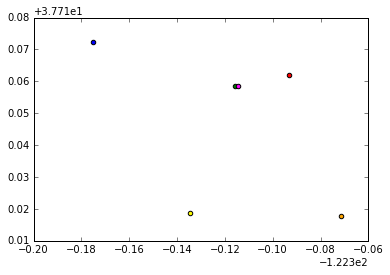

In [309]:
a1 = intersection_graph[np.random.choice(intersection_graph.keys())]
a2 = intersection_graph[np.random.choice(intersection_graph.keys())]
a3 = intersection_graph[np.random.choice(intersection_graph.keys())]
a4 = intersection_graph[np.random.choice(intersection_graph.keys())]
a5 = intersection_graph[np.random.choice(intersection_graph.keys())]
a6 = intersection_graph[np.random.choice(intersection_graph.keys())]

plt.figure(figsize=(15,15))
plt.scatter(a1.get_x_y()[0], a1.get_x_y()[1], c='red')
plt.scatter(a2.get_x_y()[0], a2.get_x_y()[1], c='green')
plt.scatter(a3.get_x_y()[0], a3.get_x_y()[1], c='blue')
plt.scatter(a4.get_x_y()[0], a4.get_x_y()[1], c='yellow')
plt.scatter(a5.get_x_y()[0], a5.get_x_y()[1], c='orange')
plt.scatter(a6.get_x_y()[0], a6.get_x_y()[1], c='magenta')

In [307]:
start_id = a6

In [310]:
begin = intersection_graph[start_id.id]
goal = intersection_graph[a6.id]

In [319]:
end_id = a6

In [320]:
with open('san_fran_start_end_points', 'wb') as f:
    pickle.dump([start_id, end_id], f)

In [311]:
def get_safe_road_cost_with_elevation(road_list, connection_list, intersection_graph, connection_dict):
    distance = 0
    for connection_id in connection_list:
        multiplier = 10000
        weight = 5*connection_dict[connection_id].get_accidents() + 1
        distance += (max(multiplier*connection_dict[connection_id].get_distance(), 1))*weight
        distance += np.abs(connection_dict[connection_id].delta_elevation)
    return distance

In [312]:
import time
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_road_cost)
end = time.time()
print 'Cost: Distance, Time: ', (end-start)
start = time.time()
safe_route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost, null_heuristic)
end = time.time()
print 'Cost: Accidents + distance, Time: ', (end-start)
start = time.time()
safe_route_with_elevation = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation)
end = time.time()
print 'Cost: Accidents + distance + elevation, Time: ', (end-start)

Cost: Distance, Time:  3.27795910835
Cost: Accidents + distance, Time:  4.61435198784
Cost: Accidents + distance + elevation, Time:  6.71872401237


In [313]:
distance_cost = get_road_cost(route['nodes'], route['connections'], intersection_graph, connection_dict)
distance_accidents_cost = get_road_cost(safe_route['nodes'], safe_route['connections'], intersection_graph, connection_dict)
distance_accidents_elevation_cost = get_road_cost(safe_route_with_elevation['nodes'], safe_route_with_elevation['connections'], intersection_graph, connection_dict)

In [317]:
print 'distance', distance_cost
print 'distance', distance_accidents_cost
print 'distance', distance_accidents_elevation_cost

distance 0.0945921159558
distance 0.0957078777384
distance 0.0991551144271


In [315]:
def plot_graph(intersection_graph, connection_dict, routes = [], safe_routes=[], ax = None):
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(15, 15))

    xs = [intersection_graph[key].get_x_y()[0] for key in intersection_graph]
    ys = [intersection_graph[key].get_x_y()[1] for key in intersection_graph]

    for key in intersection_graph:
        node = intersection_graph[key]
        for connection in node.get_connections():
            child = connection_dict[connection]
            line_x = [child.get_source(intersection_graph).get_x_y()[0], child.get_target(intersection_graph).get_x_y()[0]]
            line_y = [child.get_source(intersection_graph).get_x_y()[1], child.get_target(intersection_graph).get_x_y()[1]]
            ax.plot(line_x, line_y, color='#d3d3d3', zorder=1)

    ax.scatter(xs, ys, s=10, color='#7e7e7e', zorder=1)

    for route in routes:
        xs = [intersection_graph[node].get_x_y()[0] for node in route]
        ys = [intersection_graph[node].get_x_y()[1] for node in route]
        ax.plot(xs, ys, linewidth=7, linestyle='dashed', zorder=3)

    for route in safe_routes:
        xs = [intersection_graph[node].get_x_y()[0] for node in route]
        ys = [intersection_graph[node].get_x_y()[1] for node in route]
        ax.plot(xs, ys, linewidth=3, zorder=3)

    # plt.show()
    return ax

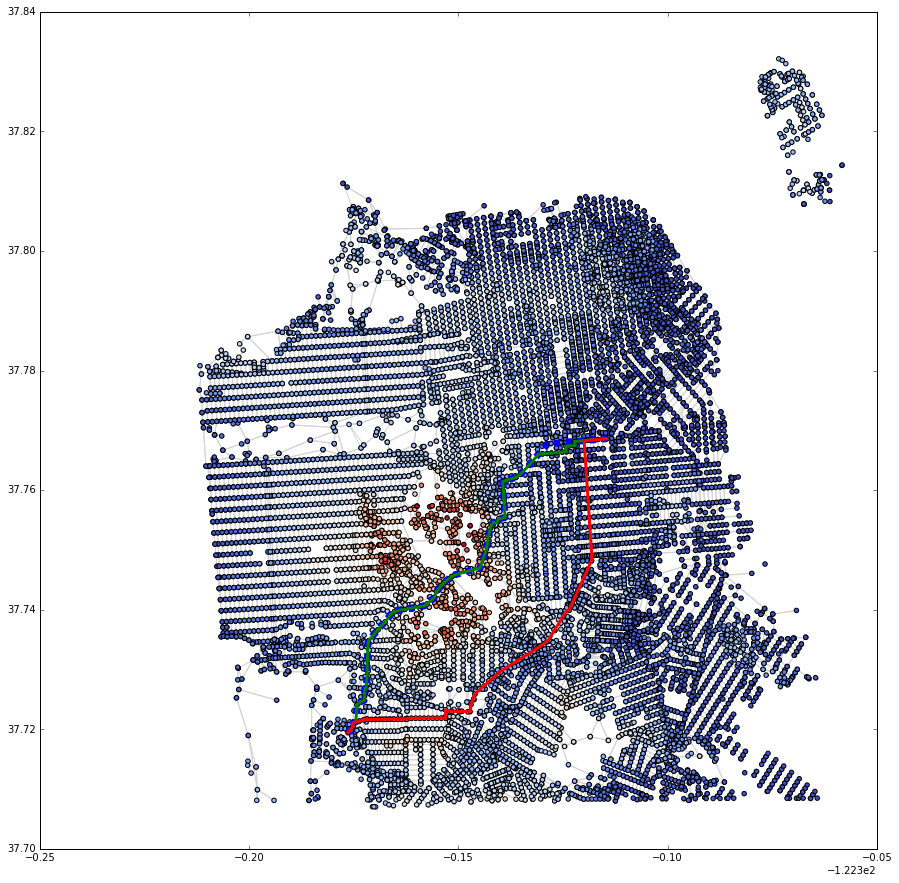

In [316]:
axis = plot_graph(intersection_graph, connection_dict, [route['nodes']], [safe_route['nodes'], safe_route_with_elevation['nodes']])
# axis.scatter(accident_lng, accident_lat, color='yellow')
colors = plt.cm.coolwarm(np.divide(elev_vals-np.min(elev_vals), np.max(elev_vals-np.min(elev_vals))))
axis.scatter(elev_lng, elev_lat, c=colors, zorder=2)

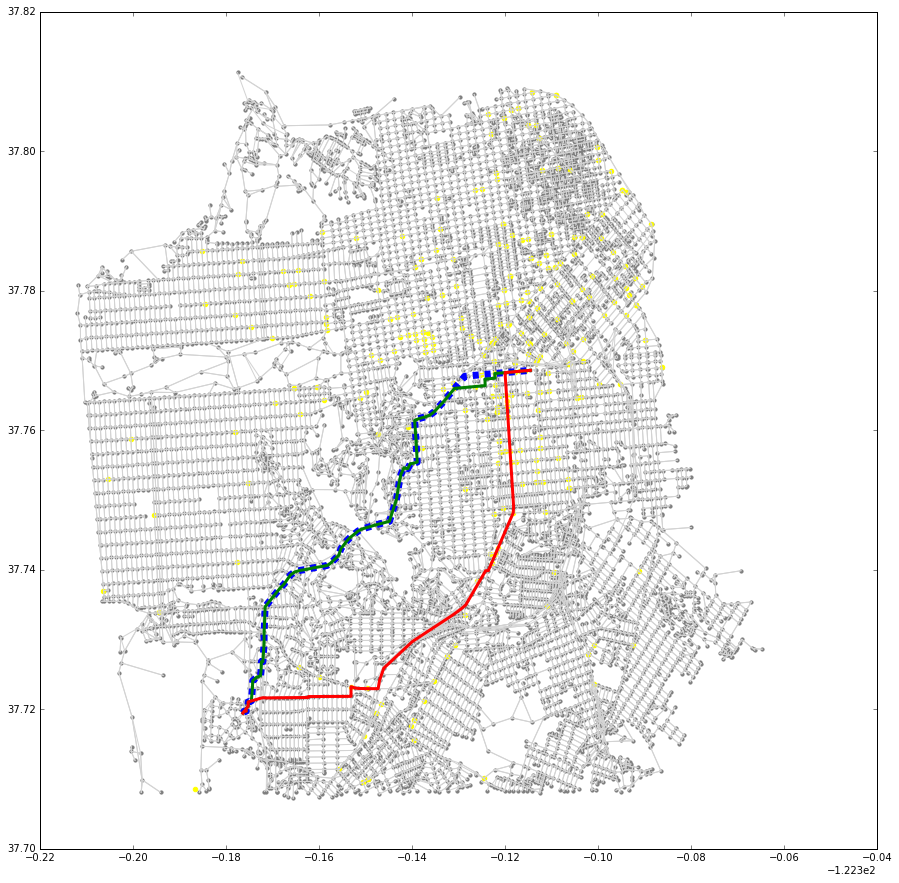

In [318]:
axis = plot_graph(intersection_graph, connection_dict, [route['nodes']], [safe_route['nodes'], safe_route_with_elevation['nodes']])
axis.scatter(accident_lng, accident_lat, color='yellow')

## Heuristics

In [168]:
[p1,p2,p3,p4,best_centroid, best_centroid, k_points] = vals
begin = intersection_graph[np.random.choice(intersection_graph.keys())]
goal = intersection_graph[np.random.choice(intersection_graph.keys())]

In [321]:
begin = start_id
goal = end_id

In [331]:
def combined_heuristic(node, goal, intersection_graph, connection_dict):
    accident_heuristic = 1
    if node.get_connections():
        accident_heuristic += (np.min([connection_dict[c].get_accidents() for c in node.get_connections()]))
    distance = euclidean_distance(node.get_x_y(), goal.get_x_y())
    elevation = goal.get_elevation() - node.get_elevation()
    return (distance*10 + elevation)*accident_heuristic

In [332]:
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, null_heuristic)
end = time.time()
print 'null heuristic, Time: ', (end-start)
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, euclidean_heuristic)
end = time.time()
print 'euclidean heuristic, Time: ', (end-start)
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, combined_heuristic)
end = time.time()
print 'combined heuristic, Time: ', (end-start)

null heuristic, Time:  6.01623415947
euclidean heuristic, Time:  6.02293992043
combined heuristic, Time:  6.66374802589


In [ ]:
axis = plot_graph(intersection_graph, connection_dict, [route['nodes']], [])
axis.scatter(accident_lng, accident_lat, color='yellow')